In [90]:
import cv2
import numpy
import random
import torch 
from torch import nn
from torchvision import datasets, transforms,utils
import matplotlib.pyplot as plt
import tqdm.notebook as tdm
def pic_r(pic=numpy.ndarray(1)):
    x,y,r = random.randint(-10,10),random.randint(-10,10),random.randint(-45,45)
    M=cv2.getRotationMatrix2D((22,22),r,1)
    picrt=cv2.resize(pic,(44+x,44+y))
    picrt=cv2.warpAffine(picrt,M,(50,50))
    return picrt

imgorg={}
for i in range(26):
    C= i
    picpath='C:/ctf/pic/images/y_%02d.png'%(i+1)
    imgorg[C]=~cv2.imread(picpath,1)[0:43,0:43]//255
t_x=[]
t_y=[]
for i in tdm.trange(1000):
    for j in imgorg:
        t_x.append(pic_r(imgorg[j]))
        t_y.append(j)
p_x=[]
p_y=[]
for i in tdm.trange(100):
    for j in imgorg:
        p_x.append(pic_r(imgorg[j]))
        p_y.append(j)

t_x = torch.tensor(np.array(t_x).transpose(0,3,1,2), dtype=torch.float)
t_y= torch.tensor(np.array(t_y), dtype=torch.long)

p_x = torch.tensor(np.array(p_x).transpose(0,3,1,2), dtype=torch.float)
p_y= torch.tensor(np.array(p_y), dtype=torch.long)

# q_x = torch.tensor(np.array(q_x), dtype=torch.float)
# q_y= torch.tensor(np.array(q_y), dtype=torch.long)

t_y

tensor([ 0,  1,  2,  ..., 23, 24, 25])

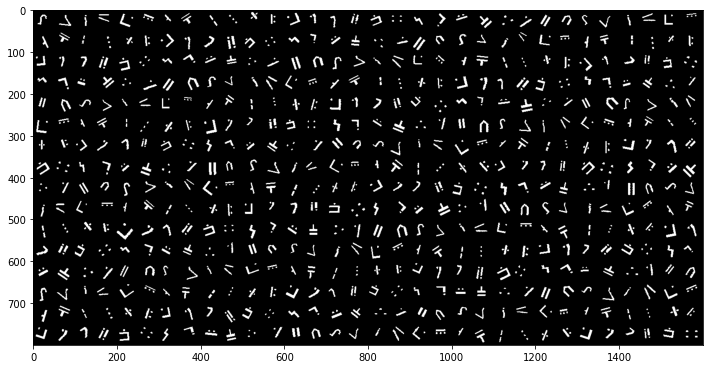

In [91]:
imgs=numpy.array(t_x[:512])
images=torch.tensor(imgs)
grid = utils.make_grid(images,32,padding=0)
grid2 = grid.numpy().transpose(1,2,0) 
plt.figure(figsize=(12,12))
# # plt.figure(figsize=(20,20))
plt.imshow(grid2)
plt.show()



In [101]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fh0 = nn.Linear(294912,1024*3)#两个池化，所以是7*7而不是14*14
#         self.fh1 = nn.Linear(1024*3,1024)
        self.fh2 = nn.Linear(1024*3,256)
        
        self.fo = nn.Linear(256,26)
        self.dp = nn.Dropout(p=0.2)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 294912)#将数据平整为一维的 
        x = self.dp(x)
        x = F.relu(self.fh0(x))
        x = self.dp(x)
#         x = F.relu(self.fh1(x))
        x = F.relu(self.fh2(x))  
        x = self.dp(x)
        x = self.fo(x)  
#        x = F.log_softmax(x,dim=1) #NLLLoss()才需要，交叉熵不需要
        return x

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    fig, axes = plt.subplots(1, 2, figsize=[16, 5])
    sns.lineplot(iters, costs,color='red',label=label_cost, ax = axes[0]) 
    sns.lineplot(iters, accs,color='green',label=lable_acc,ax=axes[1]) 
    plt.show()


In [99]:
import numpy as np
net = CNN()


In [100]:
import datetime as dt
import tqdm.notebook as tqnb
tstart=dt.datetime.now()
train_accs = []
train_loss = []
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adagrad(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(),lr=0.001)#Adam优化方法比较时髦
b_size=32
roundx=2
pbar = tqnb.tqdm(total=len(t_x)//b_size*roundx)

for epoch in range(roundx):
    running_loss = 0.0
    for i  in  range(0,len(t_x),b_size):#0是下标起始位置默认为0
        inputs,labels = t_x[i:i+b_size].to(device), t_y[i:i+b_size].to(device)
        optimizer.zero_grad()         
        #前向+后向+优化     

        outputs = net.forward(inputs)
        print(outputs,labels)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
#         if i%100 == 99:
#             print('%d,%d-%.3f' % (epoch+1,i+1,running_loss/100), end='|')
#             running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)
        pbar.update(1)
pbar.close()
torch.cuda.empty_cache()
dt.datetime.now()-tstart

import seaborn as sns

draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')
print(train_accs[-20:])
print(dt.datetime.now()-tstart)

tensor([[-3.2526, -3.2206, -3.3051, -3.2535, -3.2623, -3.2618, -3.3172, -3.2268,
         -3.3213, -3.2027, -3.2734, -3.1986, -3.3081, -3.2465, -3.2828, -3.2564,
         -3.2773, -3.2153, -3.2328, -3.2339, -3.1946, -3.2226, -3.2561, -3.2962,
         -3.3241, -3.2867]], grad_fn=<LogSoftmaxBackward>) tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5])


ValueError: Expected input batch_size (1) to match target batch_size (32).